<a href="https://colab.research.google.com/github/shaojiezhanglalala/MachineLearning/blob/main/nn_demo01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [16]:
from torch.utils.data.dataset import T
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, 
                        shuffle=True, num_workers=0)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                      transform=transform, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, 
                      shuffle=False, num_workers=0)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [5]:
import matplotlib.pyplot as plt
import numpy as np

In [17]:
def imshow(img):
  img = img / 2 + 0.5   #unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

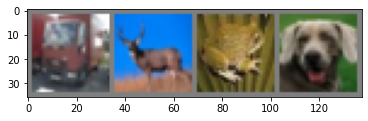

  truck   deer   frog    dog


In [20]:
detaiter = iter(trainloader)
images, labels = detaiter.next()
imshow(torchvision.utils.make_grid(images))
print(''.join('%7s' % classes[labels[j]] for j in range(4)))


In [22]:
import torch.nn as nn
import torch.nn.functional as F

In [23]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
  
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    # flatten
    x = x.view(-1, 16*5*5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x



In [24]:
import torch.optim as optim

net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [25]:
# 训练网络
for epoch in range(2):
  run_loss = 0

  for i, data in enumerate(trainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    run_loss += loss.item()
    if i % 2000 == 1999:
      print('[%d, %5d] loss: %.3f' %(epoch+1, i+1, run_loss / 2000))
      run_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.214
[1,  4000] loss: 1.944
[1,  6000] loss: 1.763
[1,  8000] loss: 1.628
[1, 10000] loss: 1.560
[1, 12000] loss: 1.495
[2,  2000] loss: 1.427
[2,  4000] loss: 1.371
[2,  6000] loss: 1.363
[2,  8000] loss: 1.339
[2, 10000] loss: 1.316
[2, 12000] loss: 1.274
Finished Training


In [26]:
# 保存训练好的模型
path = './cifar_net.pth'
torch.save(net.state_dict, path)

In [ ]:
# 加载保存的模型
net = Net()
net.load_state_dict(torch.load(path))

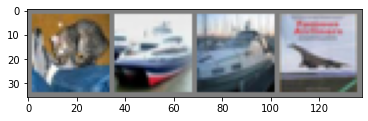

GroundTruth:     cat   ship   ship  plane
Accuracy of the network on the 10000 test images: 52 %


In [29]:
# 测试训练效果
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth:', ''.join('%7s' % classes[labels[j]] for j in range(4)))

# 测试数据集

correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, dim=1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [34]:
# 观察那些类表现好，哪些类表现不好
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  t = 0
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs, dim=1)
    c = (predicted == labels).squeeze()
    if t==0:
      print(c)
      for i in range(4):
        print(c[i].item())
    t += 1
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

for i in range(10):
  print('Accuracy of %5s, : %2d %%' % (classes[i], 
                  100 * class_correct[i] / class_total[i]))

tensor([ True, False, False, False])
True
False
False
False
Accuracy of plane, : 61 %
Accuracy of   car, : 72 %
Accuracy of  bird, : 61 %
Accuracy of   cat, : 27 %
Accuracy of  deer, : 57 %
Accuracy of   dog, : 30 %
Accuracy of  frog, : 59 %
Accuracy of horse, : 52 %
Accuracy of  ship, : 54 %
Accuracy of truck, : 50 %


In [38]:
# 在GPU上训练
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [55]:
# 将模型转换到gpu上
net = Net()
net.to(device)
# 训练网络
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
for epoch in range(2):
  run_loss = 0

  for i, data in enumerate(trainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data[0].to(device), data[1].to(device)
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    run_loss += loss.item()
    if i % 2000 == 1999:
      print('[%d, %5d] loss: %.3f' %(epoch+1, i+1, run_loss / 2000))
      run_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.211
[1,  4000] loss: 1.838
[1,  6000] loss: 1.689
[1,  8000] loss: 1.590
[1, 10000] loss: 1.543
[1, 12000] loss: 1.469
[2,  2000] loss: 1.427
[2,  4000] loss: 1.374
[2,  6000] loss: 1.355
[2,  8000] loss: 1.366
[2, 10000] loss: 1.315
[2, 12000] loss: 1.305
Finished Training


In [57]:
# 观察那些类表现好，哪些类表现不好
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  t = 0
  for data in testloader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs, dim=1)
    c = (predicted == labels).squeeze()
    if t==0:
      print(c)
      for i in range(4):
        print(c[i].item())
    t += 1
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

for i in range(10):
  print('Accuracy of %5s, : %2d %%' % (classes[i], 
                  100 * class_correct[i] / class_total[i]))

tensor([False,  True,  True, False], device='cuda:0')
False
True
True
False
Accuracy of plane, : 46 %
Accuracy of   car, : 69 %
Accuracy of  bird, : 71 %
Accuracy of   cat, : 39 %
Accuracy of  deer, : 24 %
Accuracy of   dog, : 28 %
Accuracy of  frog, : 63 %
Accuracy of horse, : 45 %
Accuracy of  ship, : 80 %
Accuracy of truck, : 41 %
